<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

In [1]:
%load_ext autoreload
%autoreload 2

The objective in this exercise is to build the functions that you will need to create your histogram filter. The histogram filter represents the state as a fixed set of hypotheses that correspond to the centroids of evenly spaced cells. Each one of these hypothesis has an associated weight, and the weights should sum to one. As a result, the histogram corresponds to a valid belief distribution over the state space. In math we can write this as a weighted sum of Dirac delta functions:

$bel(x_t) =  \sum_{i=1}^N w^i_t \delta(x_t - x^i)$

The API for this (and really any) filter will comprise three functions: `prior()`, `predict()` and `update()`. The `prior()` function sets up the initial belief weights, $w_0$ over the histogram. 

The `predict()` function propagates forward the belief weights based on the motion model and the control, $u_t$. This amounts to propagating the centroids of each of the cells forward and then adding all of the weight up that lands in each bin. 

$\overline{bel}(x_t) =  \sum_{i=1}^N \sum_{j=1}^N w_{t-1}^j p(x^i|x^j,u_t) \delta(x_t - x^i)$

In our case we will be using the odometry as a proxy for the control input so that we may use a simple kinematic model of the robot. 

Finally, the `update()` function takes a measurement and uses it to update the weights of the histogram bins based on the incoming measurement, $z_t$. This is achieved by multiplying the weight in each bin by the likelihood that the measurement was generated by the state corresponding to the centroid of that bin:

$bel(x_t) = \sum_{i=1}^N \frac{\overline{w}^i_t p(z_t|x^i)}{\displaystyle\sum_{j=1}^N \overline{w}^j_t p(z_t|x^j)}\delta(x_t - x^i)$

In this notebook we will proceed by loading one image and using the line detection and ground projection algorithms (we can consider them as a black box here) to detect all of the white and yellow line segments. Each line segment will contribute a vote in the measurement likelihood. 

After completing the notebook, apply the same concepts in the functions within [histogram_filter.py](../../packages/solution/histogram_filter.py) (fill in the TODOs).

After running `dts code build` these functions can be used on the simulated or real Duckiebot using `dts code workbench --sim` or `dts code workbench -b <ROBOT_NAME>`. This will use the real (or simulated) data coming from your camera instead of the single image that we loaded here. 


In [1]:
# start by importing some things we will need
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import entropy, multivariate_normal
from math import floor, sqrt

/tmp/ipykernel_45310/3675489234.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


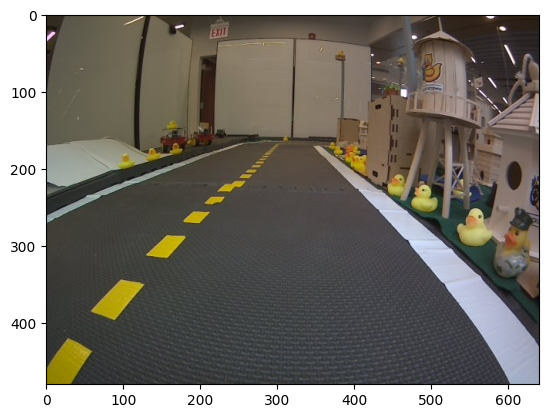

In [2]:
# Now let's load the image that we will use. Feel free to change it, 
# but the calibrations in the setup/calibrations folder should correspond to the robot
# that took the image
from matplotlib.pyplot import imshow
%matplotlib inline
img = cv2.imread("../../assets/images/pic1.png")
imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

We will define the state here to be the comprised of the distance from the center of the lane $d$ and the angle relative to the lane $\phi$. 

![](../../assets/images/state.png)

In [3]:
# Now we will load parameters from the configuration file
# These are the same parameters that will be loaded when we do 
# dts code workbench. Feel free to experiment with different values
# for any of the parameters
import yaml
with open("../../packages/histogram_lane_filter/config/histogram_lane_filter_node/default.yaml", "r") as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
hp = params["lane_filter_histogram_configuration"]
print(hp)

d, phi = np.mgrid[hp['d_min'] : hp['d_max'] : hp['delta_d'], hp['phi_min'] : hp['phi_max'] : hp['delta_phi']]

# We are going to organize them into some data structures so that they are easier to move around
grid_spec = {
    "d": d,
    "phi": phi,
    "delta_d": hp['delta_d'],
    "delta_phi": hp['delta_phi'],
    "d_min": hp['d_min'],
    "d_max": hp['d_max'],
    "phi_min": hp['phi_min'],
    "phi_max": hp['phi_max'],
}
road_spec = {
    "linewidth_white": hp['linewidth_white'],
    "linewidth_yellow": hp['linewidth_yellow'],
    "lanewidth": hp['lanewidth'],
}
robot_spec = {
    "wheel_radius": hp['wheel_radius'],
    "wheel_baseline": hp['wheel_baseline'],
    "encoder_resolution": hp['encoder_resolution'],
}

# The "cov_mask" is effectively the process model covariance
cov_mask = [hp['sigma_d_mask'], hp['sigma_phi_mask']]
belief = np.empty(d.shape)
mean_0 = [hp['mean_d_0'], hp['mean_phi_0']]
cov_0 = [[hp['sigma_d_0'], 0], [0, hp['sigma_phi_0']]]


{'mean_d_0': 0, 'mean_phi_0': 0, 'sigma_d_0': 0.1, 'sigma_phi_0': 0.1, 'delta_d': 0.02, 'delta_phi': 0.1, 'd_max': 0.3, 'd_min': -0.3, 'phi_min': -1.5, 'phi_max': 1.5, 'linewidth_white': 0.05, 'linewidth_yellow': 0.025, 'lanewidth': 0.23, 'sigma_d_mask': 1.0, 'sigma_phi_mask': 2.0, 'range_min': 0.2, 'range_est': 0.45, 'range_max': 0.6, 'encoder_resolution': 135, 'wheel_radius': 0.0318, 'wheel_baseline': 0.1}


In [4]:
# Now let's define the prior function. In this case we choose
# to initialize the historgram based on a Gaussian distribution around [0,0]
def histogram_prior(belief, grid_spec, mean_0, cov_0):
    pos = np.empty(belief.shape + (2,))
    pos[:, :, 0] = grid_spec["d"]
    pos[:, :, 1] = grid_spec["phi"]
    RV = multivariate_normal(mean_0, cov_0)
    belief = RV.pdf(pos)
    return belief

In [6]:
# Now let's define the predict function




def histogram_predict(belief, left_encoder_ticks, right_encoder_ticks, grid_spec, robot_spec, cov_mask):
        belief_in = belief

        alpha = 2 * np.pi / robot_spec['encoder_resolution'] # wheel rotation per tick in radians
        d_left = robot_spec['wheel_radius'] * left_encoder_ticks * alpha
        d_right = robot_spec['wheel_radius'] * right_encoder_ticks * alpha  
        d_A = (d_left + d_right) / 2
        delta_theta = (d_right - d_left) / (2 * robot_spec['wheel_baseline'])

        # TODO propagate each centroid forward using the kinematic function
        d_t = grid_spec['d'] + d_A * np.sin(delta_theta) # replace this with something that adds the new odometry
        phi_t = grid_spec['phi'] + delta_theta # replace this with something that adds the new odometry

        p_belief = np.zeros(belief.shape)

        # Accumulate the mass for each cell as a result of the propagation step
        for i in range(belief.shape[0]):
            for j in range(belief.shape[1]):
                # If belief[i,j] there was no mass to move in the first place
                if belief[i, j] > 0:
                    # Now check that the centroid of the cell wasn't propagated out of the allowable range
                    if (
                        d_t[i, j] > grid_spec['d_max']
                        or d_t[i, j] < grid_spec['d_min']
                        or phi_t[i, j] < grid_spec['phi_min']
                        or phi_t[i, j] > grid_spec['phi_max']
                    ):
                        continue
                    
                    i_new = floor((d_t[i, j] - grid_spec['d_min']) / grid_spec['delta_d'])
                    j_new = floor((phi_t[i, j] - grid_spec['phi_min']) / grid_spec['delta_phi'])

                    p_belief[i_new, j_new] += belief[i, j]

        # Finally we are going to add some "noise" according to the process model noise
        # This is implemented as a Gaussian blur over the histogram
        s_belief = np.zeros(belief.shape)
        gaussian_filter(p_belief, cov_mask, output=s_belief, mode="constant")

        if np.sum(s_belief) == 0:
            return belief_in
        belief = s_belief / np.sum(s_belief)
        return belief


Now we are going to work on building the measurement likelihood. We will have as an input a list of segments. Each segment has endpoints, a normal vector, and an associated color. For each segment, we will use basic geometry to figure out what position ($d$) and orientation ($\phi$) the robot would have had to have been at to detect the specific segment assuming that it did in fact come from a road marking. 

There is a bit of annoying detail here since we can detect lines on either side of the actual lane markings. We use the normals to determine which side of the lane marking the line was on. The following shows the `lanewidth` and the `linewidth_yellow` and `linewidth_white` parameters.

The following image shows a representations of how the detected line segments sit on an actual lane

<p style="text-align: center">
  <img src="../../assets/images/03-histogram-filter/detected_line_segments.png" alt="detected line segments" width="200">
</p>
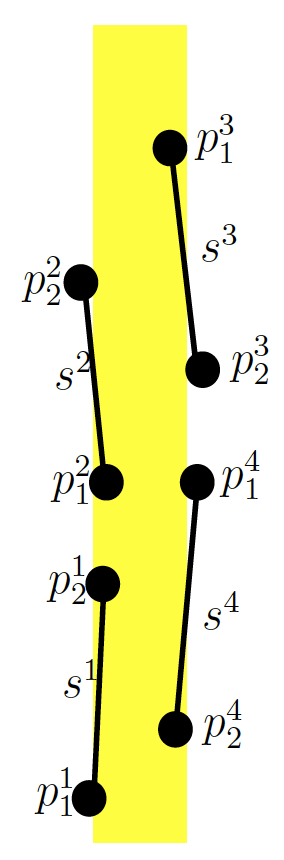

In [7]:
# We will start by doing a little bit of processing on the segments to remove anything that is behind the robot (why would it be behind?)
# or a color not equal to yellow or white

def prepare_segments(segments):
    filtered_segments = []
    for segment in segments:

        # we don't care about RED ones for now
        if segment.color != SegmentColor.WHITE and segment.color != SegmentColor.YELLOW:
            continue
        # filter out any segments that are behind us
        if segment.points[0].x < 0 or segment.points[1].x < 0:
            continue

        filtered_segments.append(segment)
    return filtered_segments

Now for each segment we will generate a vote according to:

<p style="text-align: center">
  <img src="../../assets/images/03-histogram-filter/Votingalgorithm.png" alt="detected line segments" width="1000">
</p>
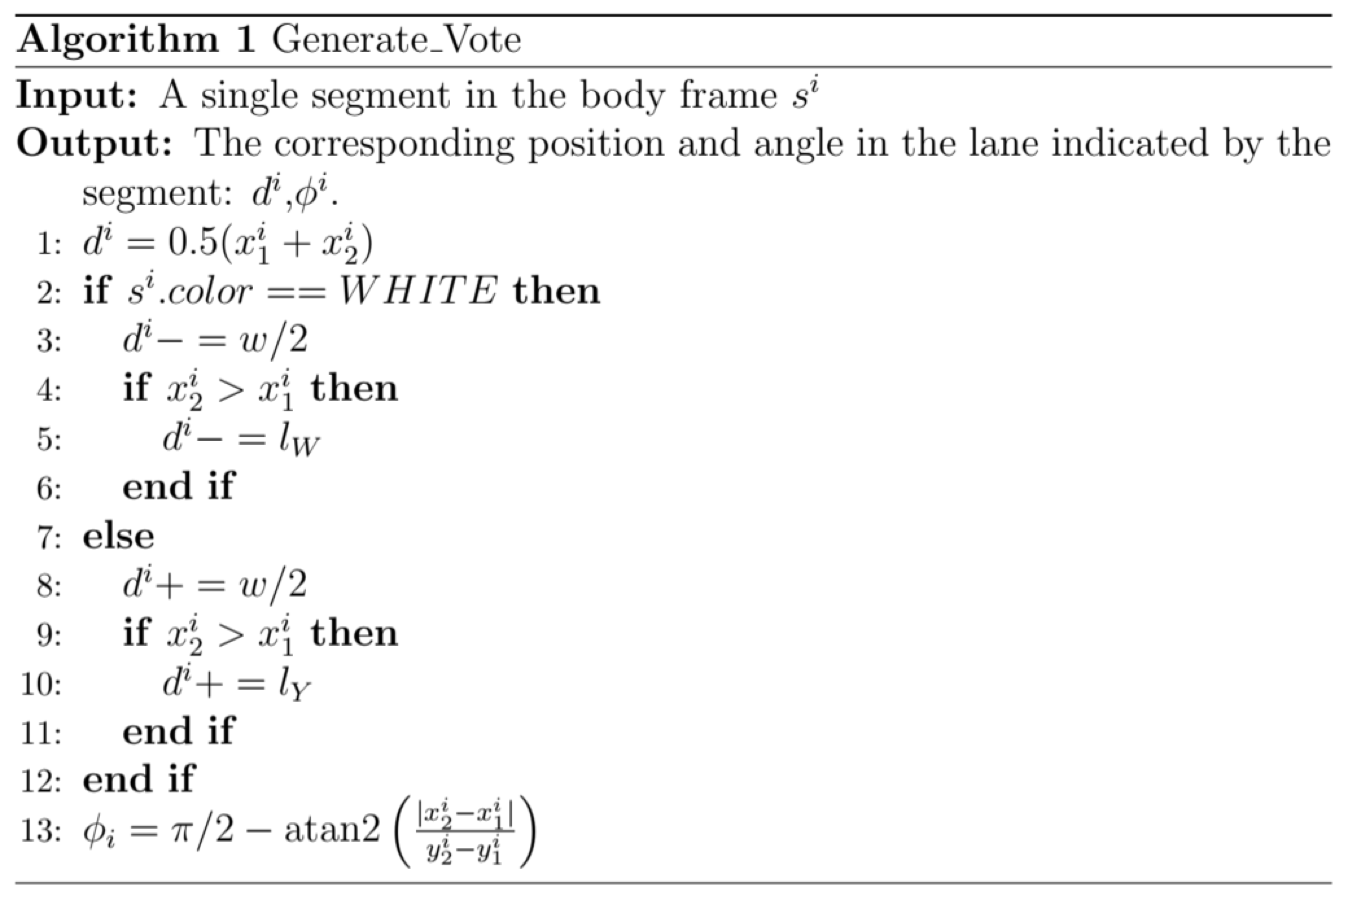

In [8]:

def generate_vote(segment, road_spec):
    p1 = segment.points[0].as_array()
    p2 = segment.points[1].as_array()
    t_hat = (p2 - p1) / np.linalg.norm(p2 - p1)

    n_hat = np.array([-t_hat[1], t_hat[0]])
    d1 = np.inner(n_hat, p1)
    d2 = np.inner(n_hat, p2)
    l1 = np.inner(t_hat, p1)
    l2 = np.inner(t_hat, p2)
    if l1 < 0:
        l1 = -l1
    if l2 < 0:
        l2 = -l2

    l_i = (l1 + l2) / 2
    d_i = (d1 + d2) / 2
    phi_i = np.arcsin(t_hat[1])
    if segment.color == SegmentColor.WHITE:  # right lane is white
        if p1[0] > p2[0]:  # right edge of white lane
            d_i -= road_spec['linewidth_white']
        else:  # left edge of white lane

            d_i = -d_i

            phi_i = -phi_i
        d_i -= road_spec['lanewidth'] / 2

    elif segment.color == SegmentColor.YELLOW:  # left lane is yellow
        if p2[0] > p1[0]:  # left edge of yellow lane
            d_i -= road_spec['linewidth_yellow']
            phi_i = -phi_i
        else:  # right edge of white lane
            d_i = -d_i
        d_i = road_spec['lanewidth'] / 2 - d_i

    return d_i, phi_i


Now we generate the entire measurement likelihood by generating a vote for each line segment in the list that we received. The measurement likelihood will itself be a histogram:

<p style="text-align: center">
  <img src="../../assets/images/03-histogram-filter/Histogram.png" alt="detected line segments" width="600">
</p>
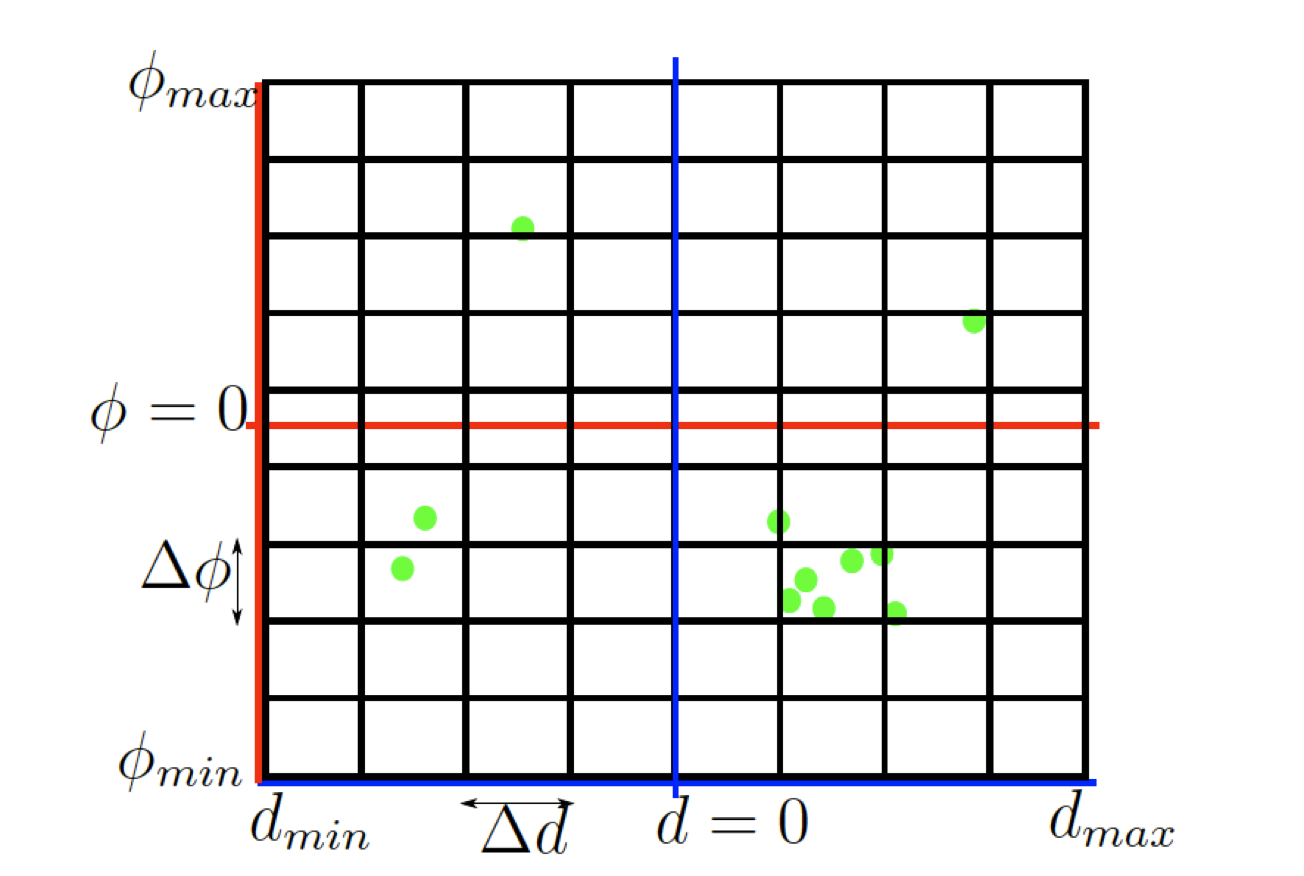

In [35]:
def generate_measurement_likelihood(segments, road_spec, grid_spec):

    # initialize measurement likelihood to all zeros
    measurement_likelihood = np.zeros(grid_spec['d'].shape)

    for segment in segments:
        d_i, phi_i = generate_vote(segment, road_spec)

        # if the vote lands outside of the histogram discard it
        if d_i > grid_spec['d_max'] or d_i < grid_spec['d_min'] or phi_i < grid_spec['phi_min'] or phi_i > grid_spec['phi_max']:
            continue

        # TODO find the cell index that corresponds to the measurement d_i, phi_i
        i = floor((d_i - grid_spec['d_min']) / grid_spec['delta_d'])
        j = floor((phi_i - grid_spec['phi_min']) / grid_spec['delta_phi'])
        
        # Add one vote to that cell
        measurement_likelihood[i, j] += 1

    if np.linalg.norm(measurement_likelihood) == 0:
        return None
    measurement_likelihood /= np.sum(measurement_likelihood)
    return measurement_likelihood


Now we have everything we need for the update function. 

In [10]:
def histogram_update(belief, segments, road_spec, grid_spec):
    # prepare the segments for each belief array
    segmentsArray = prepare_segments(segments)
    # generate all belief arrays

    measurement_likelihood = generate_measurement_likelihood(segmentsArray, road_spec, grid_spec)

    if measurement_likelihood is not None:
        # TODO: combine the prior belief and the measurement likelihood to get the posterior belief
        # Don't forget that you may need to normalize to ensure that the output is valid probability distribution
        belief = measurement_likelihood * belief / np.sum(measurement_likelihood * belief) # replace this with something that combines the belief and the measurement_likelihood
    return (measurement_likelihood, belief)


Now we have defined the `prior()`, `predict()` and `update()` functions. We will test one cycle of the filter here to see if things look reasonable. 

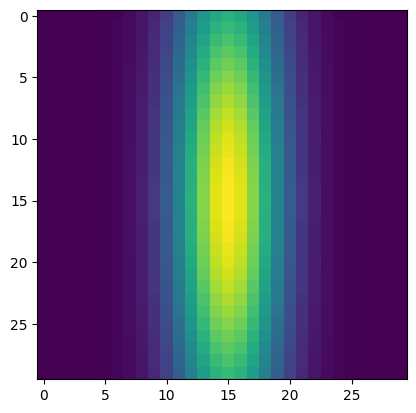

In [30]:
# Let's start initializing the belief:
belief = histogram_prior(belief, grid_spec, mean_0, cov_0)
imshow(belief)


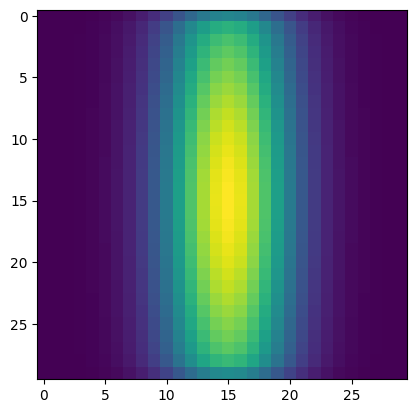

In [31]:
# Now let's generate some fake encoder data and do one step of the prediction function:

left = 10 # left ticks
right = 20 # right ticks
belief = histogram_predict(belief, left, right, grid_spec, robot_spec, cov_mask)
imshow(belief)

In [26]:
from typing import Tuple, Dict, Union, List
from dt_computer_vision.camera import CameraModel, NormalizedImagePoint, Pixel
from dt_computer_vision.ground_projection import GroundProjector
from dt_computer_vision.ground_projection.rendering import draw_grid_image, debug_image
from dt_computer_vision.ground_projection.types import GroundPoint
from dt_computer_vision.line_detection import LineDetector, ColorRange, Detections
from dt_computer_vision.line_detection.rendering import draw_segments
from dt_state_estimation.lane_filter.types import Segment, SegmentColor, SegmentPoint




# This code will take the image that we loaded, detect the line segments, and project them onto the ground plane. 
# We don't need to worry too much about details here.
Color = Tuple[int, int, int]

camera_info: Dict[str, Union[np.ndarray, int]] = \
    {
        "width": 640,
        "height": 480,
        "K": np.reshape(
            [
                295.79606866959824,
                0.0,
                321.2621599038631,
                0.0,
                299.5389048862878,
                241.73616515312332,
                0.0,
                0.0,
                1.0,
            ],
            (3, 3)
        ),
        "D": [
            -0.23543978771661125,
            0.03637781479419574,
            -0.0033069818601306755,
            -0.0012140708179525926,
            0.0,
        ],
        "P": np.reshape(
            [
                201.14027404785156,
                0.0,
                319.5586620845679,
                0.0,
                0.0,
                239.74398803710938,
                237.60151004037834,
                0.0,
                0.0,
                0.0,
                1.0,
                0.0,
            ],
            (3, 4)
        ),
        "H": np.reshape(
            [
                8.56148231e-03,
                2.22480148e-01,
                4.24318934e-01,
                -5.67022044e-01,
                -1.13258040e-03,
                6.81113839e-04,
                5.80917161e-02,
                4.35079347e+00,
                1.0],
            (3, 3)
        ),
    }
crop_top = 200
image_crop = [0, crop_top, 640, camera_info["height"] - crop_top]
x, y, w, h = image_crop
img_cropped = img[y:y + h, x:x + w, :]
_K = camera_info["K"]
_K[0][2] = _K[0][2] - x
_K[1][2] = _K[1][2] - y
# - update P
_P = camera_info["P"]
_P[0][2] = _P[0][2] - x
_P[1][2] = _P[1][2] - y


# colors
color_ranges: Dict[str, ColorRange] = {
    "white": ColorRange.fromDict({
        "low": [0, 0, 150],
        "high": [180, 100, 255]
    }),
    "yellow": ColorRange.fromDict({
        "low": [0, 100, 100],
        "high": [45, 255, 255]
    })
}
colors: Dict[str, Color] = {
    "red": (0, 0, 255),
    "yellow": (0, 255, 255),
    "white": (255, 255, 255),
}
color_order = ["yellow", "white"]
colors_to_detect = [color_ranges[c] for c in color_order]


In [27]:

def detect_lines(img_cropped):
    
    detector = LineDetector()
    color_detections: List[Detections] = detector.detect(img_cropped, colors_to_detect)
    lines: Dict[str, dict] = {}
    for i, detections in enumerate(color_detections):
        color = color_order[i]
        # pack detections in a dictionary
        lines[color] = {
            "lines": detections.lines.tolist(),
            "centers": detections.centers.tolist(),
            "normals": detections.normals.tolist(),
            "color": color_ranges[color].representative
        }
    image_w_dets = draw_segments(img_cropped, {color_ranges["yellow"]: color_detections[0]})
    image_w_dets = draw_segments(image_w_dets, {color_ranges["white"]: color_detections[1]})
    plt.figure(0)
    imshow(cv2.cvtColor(image_w_dets,cv2.COLOR_BGR2RGB))
    return lines


In [33]:
def lines_to_projected_segments(lines):
    camera = CameraModel(
        width=camera_info["width"],
        height=camera_info["height"],
        K=camera_info["K"],
        D=camera_info["D"],
        P=camera_info["P"],
        H=camera_info["H"],
    )
    projector = GroundProjector(camera)
    segments: List[Segment] = []
    colored_segments: Dict[Color, List[Tuple[GroundPoint, GroundPoint]]] = {}
    grid = draw_grid_image((400, 400))

    for color, colored_lines in lines.items():
        grounded_segments: List[Tuple[GroundPoint, GroundPoint]] = []
        for line in colored_lines["lines"]:
            # distorted pixels
            p0: Pixel = Pixel(line[0], line[1])
            p1: Pixel = Pixel(line[2], line[3])
            # distorted pixels to rectified pixels
            p0_rect: Pixel = camera.rectifier.rectify_pixel(p0)
            p1_rect: Pixel = camera.rectifier.rectify_pixel(p1)
            # rectified pixel to normalized coordinates
            p0_norm: NormalizedImagePoint = camera.pixel2vector(p0_rect)
            p1_norm: NormalizedImagePoint = camera.pixel2vector(p1_rect)
            # project image point onto the ground plane
            grounded_p0: SegmentPoint = projector.vector2ground(p0_norm)
            grounded_p1: SegmentPoint = projector.vector2ground(p1_norm)
            # add grounded segment to output
            segments.append(Segment(
                points=[grounded_p0, grounded_p1],
                color=SegmentColor(color)
            ))
            grounded_segments.append((grounded_p0, grounded_p1))

        colored_segments[colors[color]] = grounded_segments
    image_w_segs = debug_image(colored_segments, (400, 400), background_image=grid)
    image_w_segs_rgb = image_w_segs[:, :, [2, 1, 0]]
    plt.figure(1)
    imshow(image_w_segs_rgb)
    return segments



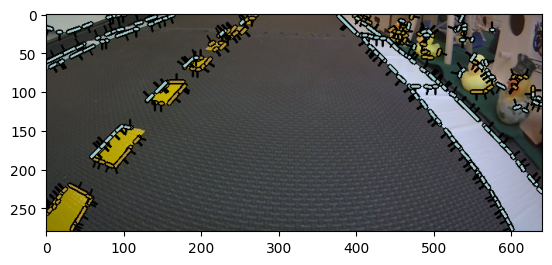

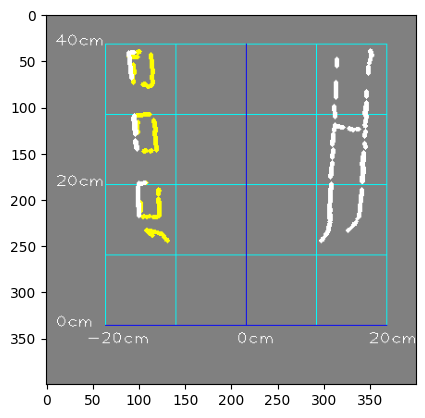

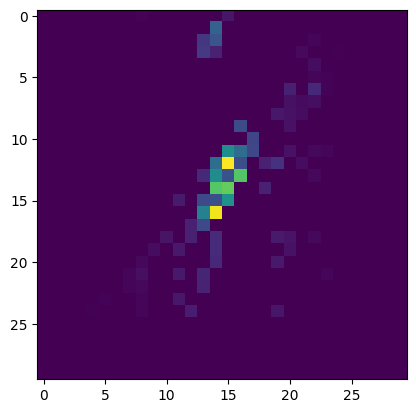

In [36]:
%matplotlib inline

lines = detect_lines(img_cropped)
segments = lines_to_projected_segments(lines)
# Finally we can take the ground projected segments and call our update function
(measurement_likelihood, belief) = histogram_update(belief, segments, road_spec, grid_spec)
plt.figure(2)
imshow(belief)

After completing the notebook, apply the same concepts in the functions within [histogram_filter.py](../../packages/solution/histogram_filter.py) (fill in the TODOs) and then test it with the process described in the [README](../../README.md).